In [1]:
import numpy as np
import pandas as pd
import import_ipynb
import glob
import copy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [2]:
countries={ 'Austria': 'AT', 'Belgium': 'BE',  'Bulgaria': 'BG', 'Switzerland': 'CH', 'Czech Republic': 'CZ',  'Germany': 'DE', 'Denmark': 'DK', 'Estonia': 'EE', 'Spain': 'ES', 'Finland': 'FI', 'France': 'FR',  'Greece': 'GR', 'Hungary': 'HU', 'Ireland': 'IE', 'Italy': 'IT', 'Lithuania': 'LT', 'Latvia': 'LV', 'Montenegro': 'ME','Netherlands': 'NL', 'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 'Serbia': 'RS', 'Sweden': 'SE', 'Slovenia': 'SI', 'Slovakia': 'SK', 'United Kingdom': 'GB'}

abbr_list=list(countries.values())

In [ ]:
fuels=['Biomass', 'Fossil Brown coal/Lignite', 'Fossil Coal-derived gas', 'Fossil Gas', 'Fossil Hard coal', 'Fossil Oil', 'Fossil Oil shale', 'Fossil Peat', 'Geothermal', 'Hydro Pumped Storage', 'Hydro Pumped Storage', 'Hydro Run-of-river and poundage', 'Hydro Water Reservoir', 'Marine', 'Nuclear', 'Other', 'Other renewable', 'Solar', 'Waste', 'Wind Offshore', 'Wind Onshore']

In [ ]:
import matplotlib.pyplot as plt 

# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import train_test_split

In [3]:
import internal_inconsistencies as ii
import random

importing Jupyter notebook from internal_inconsistencies.ipynb
importing Jupyter notebook from data_preperation.ipynb


## Check total missing values

## Fill missing values

In [97]:
country = 'Belgium'
inc = False
df = pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/Generation per unit/{country}.csv', low_memory=False)
for column in df.columns.values:
    if df.loc[1, column] == 'Actual Consumption':
        df=df.drop(column,axis=1)
        inc = True
if inc:
    df = df.drop(index=1)
df=df.replace(['n/e',np.nan],0)
df = df.T
# print(df)
gen = list(set(df.iloc[:, 0].values))
df = df.groupby(df.iloc[:,0])
for item in gen[1:]:
    x=df.get_group(item).iloc[:,1:]
    tot=0
    for column in x.columns.values:
        tot+=pd.to_numeric(x.loc[:,column]).sum()
    print(item,':',tot)


Nuclear : 27255049.0
Hydro Pumped Storage : 1014065.0
Biomass : 1493407.0
Wind Offshore : 3295644.0
Fossil Gas : 17182561.0


In [98]:
country = 'Belgium'
inc = False
data = []

df_type = pd.read_csv(f"../Data Sources/ENTSO-E/2018/Generation/{country}.csv").iloc[:,2:]
df_type = df_type.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'], axis=1)
df_type = df_type.replace(['n/e', np.nan], 0)
columns = [column[:-26] for column in df_type.columns.values]
df_type.columns = columns

df_gen = pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/Generation per unit/{country}.csv', low_memory=False).iloc[:, 1:]
for column in df_gen.columns.values:
    if df_gen.loc[1, column] == 'Actual Consumption':
        df_gen = df_gen.drop(column, axis=1)
        inc = True
if inc:
    df_gen = df_gen.drop(index=1)
    df_gen = df_gen.reset_index(drop=True)
df_gen = df_gen.replace(['n/e', np.nan], 0)
df_gen = df_gen.T
generation_types = list(set(df_gen.iloc[:, 0].values))
df_gen = df_gen.groupby(df_gen.iloc[:, 0])
for item in generation_types:
    selected_data = df_gen.get_group(item).iloc[:,1:]
    tot = 0
    # tot = selected_data.iloc[1:, :].sum(axis=1).sum()
    # print(tot)
    for column in selected_data.columns.values:
        tot += pd.to_numeric(selected_data.loc[:, column]).sum()
    print(item, tot)
    data.append([country, item, tot, df_type.loc[:,item].sum()])


Hydro Pumped Storage 1014065.0
Nuclear 27255049.0
Biomass 1493407.0
Wind Offshore 3295644.0
Fossil Gas 17182561.0


In [1]:
import sys
import numpy as np
import pandas as pd
from entsoe import EntsoePandasClient
client = EntsoePandasClient(api_key='ba09e029-bc4f-417d-9d8c-05ab4ee20a4b')
countries = ['AT', 'BE',  'BG', 'CH', 'CZ',  'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
             'HU', 'IE', 'IT', 'LT', 'LV', 'ME', 'NL', 'NO', 'PL', 'PT', 'RS', 'SE', 'SI', 'SK', 'GB']
countries = countries[21:]

In [2]:
time = ['20200101', '20200201', '20200301', '20200401', '20200501', '20200601',
        '20200701', '20200801', '20200901', '20201001', '20201101', '20201201', '20210101']
uncompleted = []
for country_code in countries:  # Belgium
    yearly_df = pd.DataFrame()
    i = 0
    previous_error = 0
    counter = 0
    while i < len(time)-1:
        start = pd.Timestamp(time[i], tz='Europe/Brussels')
        end = pd.Timestamp(time[i+1], tz='Europe/Brussels')
        try:
            df = client.query_generation_per_plant(
                country_code, start=start, end=end, psr_type=None)
            print(country_code, time[i])
            yearly_df = pd.concat([yearly_df, df], sort=False)
            i += 1

        except:
            error = i
            if error == previous_error:
                counter += 1
            else:
                counter = 0
            previous_error = error
            if counter == 10:
                print('Other Error')
                uncompleted.append(country_code)
                break

    if counter != 10:
        yearly_df.to_csv(
            f'C:/Users/lovin/Google Drive/Master Thesis/Python Code/Data Sources/ENTSO-E/2020/Generation/Generation per unit/{country_code}.csv')
print(uncompleted)


LT 20190101
LT 20190201
Connection Error, retrying in 0 seconds
LT 20190301
LT 20190401
LT 20190501
LT 20190601
LT 20190701
LT 20190801
LT 20190901
LT 20191001
LT 20191101
LT 20191201
LV 20190101
Connection Error, retrying in 0 seconds
LV 20190201
LV 20190301
Connection Error, retrying in 0 seconds
LV 20190401
LV 20190501
LV 20190601
Connection Error, retrying in 0 seconds
LV 20190701
LV 20190801
LV 20190901
LV 20191001
LV 20191101
LV 20191201
Connection Error, retrying in 0 seconds
ME 20190101
ME 20190201
ME 20190301
ME 20190401
ME 20190501
ME 20190601
Connection Error, retrying in 0 seconds
ME 20190701
Connection Error, retrying in 0 seconds
Connection Error, retrying in 0 seconds
Connection Error, retrying in 0 seconds
Connection Error, retrying in 0 seconds
Connection Error, retrying in 0 seconds
Other Error
NL 20190101
Connection Error, retrying in 0 seconds
NL 20190201
NL 20190301
NL 20190401
NL 20190501
NL 20190601
NL 20190701
NL 20190801
NL 20190901
NL 20191001
NL 20191101
NL 2

In [100]:
# import numpy as np
# import pandas as pd
# import glob
# csvs = glob.glob("../Data Sources/ENTSO-E/2018/Generation/Generation per unit/*.csv")
# data = []
# for csv in csvs:

#     df_type = pd.read_csv(f"../Data Sources/ENTSO-E/2018/Generation/{csv[60:-4]}.csv").iloc[:,2:]
#     df_type = df_type.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'], axis=1)
#     df_type = df_type.replace(['n/e', np.nan], 0)
#     columns = [column[:-26] for column in df_type.columns.values]
#     df_type.columns = columns

#     df_gen = pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/Generation per unit/{country}.csv', low_memory=False).iloc[:, 1:]

#     inc = False
#     for column in df_gen.columns.values:
#         if df_gen.loc[1, column] == 'Actual Consumption':
#             df_gen = df_gen.drop(column, axis=1)
#             inc = True
#     if inc:
#         df_gen = df_gen.drop(index=1)
#         df_gen = df_gen.reset_index(drop=True)

#     df_gen = df_gen.replace(['n/e', np.nan], 0)
#     df_gen = df_gen.T

#     generation_types = list(set(df_gen.iloc[:, 0].values))
#     df_gen = df_gen.groupby(df_gen.iloc[:, 0])
#     for item in generation_types:
#         selected_data = df_gen.get_group(item).iloc[:, 1:]
#         tot = 0
#         for column in selected_data.columns.values:
#             tot += pd.to_numeric(selected_data.loc[:, column]).sum()
#         print(csv[60:-4], item, tot, df_type.loc[:, item].sum())
#         data.append([csv[60:-4], item, tot, df_type.loc[:, item].sum()])
df = pd.DataFrame(data,columns=['Country','Generation type','Based on per generator','Based on per type'])
df

Austria Hydro Pumped Storage 1014065.0 18785868.0
Austria Nuclear 27255049.0 0
Austria Biomass 1493407.0 10300324.0
Austria Wind Offshore 3295644.0 0
Austria Fossil Gas 17182561.0 32667384.0
Belgium Hydro Pumped Storage 1014065.0 999764.0
Belgium Nuclear 27255049.0 27251673.0
Belgium Biomass 1493407.0 2619943.0
Belgium Wind Offshore 3295644.0 3321049.0
Belgium Fossil Gas 17182561.0 22303256.0
Czech Republic Hydro Pumped Storage 1014065.0 1041674.0
Czech Republic Nuclear 27255049.0 28228525.0
Czech Republic Biomass 1493407.0 2253396.0
Czech Republic Wind Offshore 3295644.0 0
Czech Republic Fossil Gas 17182561.0 3357028.0
Estonia Hydro Pumped Storage 1014065.0 0
Estonia Nuclear 27255049.0 0
Estonia Biomass 1493407.0 550672.0
Estonia Wind Offshore 3295644.0 0
Estonia Fossil Gas 17182561.0 31224.0
Finland Hydro Pumped Storage 1014065.0 0
Finland Nuclear 27255049.0 21884428.0
Finland Biomass 1493407.0 6405436.0
Finland Wind Offshore 3295644.0 0
Finland Fossil Gas 17182561.0 4999951.0
France

In [ ]:
countries = {'Austria': 'AT', 'Belgium': 'BE',  'Bulgaria': 'BG', 'Switzerland': 'CH', 'Czech Republic': 'CZ',  'Germany': 'DE', 'Denmark': 'DK', 'Estonia': 'EE', 'Spain': 'ES', 'Finland': 'FI', 'France': 'FR',  'Greece': 'GR', 'Hungary': 'HU',
             'Ireland': 'IE', 'Italy': 'IT', 'Lithuania': 'LT', 'Latvia': 'LV', 'Montenegro': 'ME', 'Netherlands': 'NL', 'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 'Serbia': 'RS', 'Sweden': 'SE', 'Slovenia': 'SI', 'Slovakia': 'SK', 'United Kingdom': 'UK'}
generation_types = {'biomass': ['Biomass  - Actual Aggregated [MW]'], 'gas': [
    'Fossil Gas  - Actual Aggregated [MW]', 'Fossil Coal-derived gas  - Actual Aggregated [MW]'], 'hard_coal': ['Fossil Hard coal  - Actual Aggregated [MW]'], 'hydro': ['Hydro Pumped Storage  - Actual Aggregated [MW]', 'Hydro Run-of-river and poundage  - Actual Aggregated [MW]', 'Hydro Water Reservoir  - Actual Aggregated [MW]', 'Marine  - Actual Aggregated [MW]'], 'lignite': ['Fossil Brown coal/Lignite  - Actual Aggregated [MW]'], 'other_fossil': ['Fossil Oil  - Actual Aggregated [MW]', 'Fossil Oil shale  - Actual Aggregated [MW]', 'Fossil Peat  - Actual Aggregated [MW]'], 'nuclear': ['Nuclear  - Actual Aggregated [MW]'], 'other_renewable': ['Other renewable  - Actual Aggregated [MW]', 'Solar  - Actual Aggregated [MW]', 'Waste  - Actual Aggregated [MW]'], 'wind_onshore': ['Wind Onshore  - Actual Aggregated [MW]'], 'wind_offshore': ['Wind Offshore  - Actual Aggregated [MW]']}
for key,value in generation_types.items():
    value.append(0)
generation = {country: copy.deepcopy(generation_types) for country in countries}
for country in countries:
    df_orig, length = ii.omit_dst(pd.read_csv(
        f'../Data Sources/ENTSO-E/2018/Generation/{country}.csv', low_memory=False).iloc[:, 2:])
    if 'Hydro Pumped Storage  - Actual Consumption [MW]' in df_orig.columns.values:
        df_orig = df_orig.drop(
            ['Hydro Pumped Storage  - Actual Consumption [MW]'], axis=1)

    df_orig = df_orig.replace(['n/e', np.nan], 0)
    if(df_orig[column] == 0).all():
        df_orig = df_orig.drop(column, axis=1)

    for column in df_orig.columns.values:
        for key, value in generation_types.items():
            if column in generation_types[key]:
                generation[country][key][-1] += df_orig[column].sum()/length

x = []
for key, values in generation.items():
    for sub_key, value in values.items():
        if value[-1] != 0:
            x.append([key, sub_key, value[-1]])
df = pd.DataFrame(x, columns=['Country', 'GenerationType', 'Value[MW]'])
df



,Country,GenerationType,Value[MW]
0,Austria,biomass,2575081.00
1,Austria,gas,8166846.00
2,Austria,hard_coal,1422419.50
3,Austria,hydro,34711096.75
4,Austria,other_renewable,2299554.75
...,...,...,...
169,United Kingdom,other_fossil,4608.50
170,United Kingdom,nuclear,60356878.00
171,United Kingdom,other_renewable,11195925.50
172,United Kingdom,wind_onshore,28812687.50


In [ ]:
def polynomial(selected_values, selected_index):

    # We get all the indexes in the 'selected_values' to a 2D numpy array 'X'.
    # We get all the values in the 'selected_values'to a 1D numpy array 'y'
    # Then we fill the null values in array 'y' with the mean value of the array.
    # Then we divide 'X' and 'y' values in the ratio of 30% test and 70% train data.
    # We create an array of degree values from 1 to 10.
    # Then we iterate the 'degrees' one by one and create polynomial values of 'x_train' data called 'x_poly_train' based on the value of the degree
    # Then we fit the polynomial linear regression function using 'x_poly_train' data and 'y_train' data.
    # Then based on the polynomial function, using the 'x_poly_test' data we predict the values of the 'y_test' data
    # Then based on the predicted values and 'y_test" data we calculate the Root Mean Square Error.
    # Applying the last 4 steps for each degree value, we select the degree value which gives the Lowest Root Mean Square Error.
    # Then we fit the polynomial linear regression function again using that degree which gives the Lowest Root Mean Square Error.
    # Based on the polynimial function we get the predicted value of the null value.

    X = np.array([i[0] for i in selected_values]
                 ).reshape(len(selected_values), 1)
    y = [i[1] for i in selected_values]
    mean = np.nanmean(y)
    y = [mean if pd.isna(x) else x for x in y]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

    degrees = np.arange(1, 11)
    min_rmse, min_deg = 1e10, 0

    for degree in degrees:

        # Preparing polynomial Train features based on x_train
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        x_poly_train = poly_features.fit_transform(x_train)

        # Polynomial linear regression based on train data
        poly_reg = LinearRegression()
        poly_reg.fit(x_poly_train, y_train)

        # Predicting y values and getting root mean squared error based on predicted y values and y_test values
        x_poly_test = poly_features.fit_transform(x_test)
        poly_predict = poly_reg.predict(x_poly_test)
        poly_mse = mean_squared_error(y_test, poly_predict)
        poly_rmse = np.sqrt(poly_mse)

        # Selecting the best degree of the polynimial function based on lowest root mean squared error
        if min_rmse > poly_rmse:
            min_rmse = poly_rmse
            min_deg = degree

    # Fitting the regression function again based on the selected best degree above
    poly_features = PolynomialFeatures(degree=min_deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    prediction = poly_reg.predict(
        poly_features.fit_transform([[selected_index]]))[0]
    if prediction < 0:
        prediction = 0

    return(min_deg,prediction)


def mean(selected_values):
    if pd.isnull(selected_values).sum() != len(selected_values):
        mean_value = np.nanmean(selected_values)
        selected_values = [mean_value if pd.isna(x) else x for x in selected_values]
        prediction = np.mean(np.array(selected_values))
    else:
        prediction = 0

    return prediction


In [ ]:
selected_values


[23071.0, 22305.0, 20971.0]

## DO NOT DELETE

In [ ]:
# x = ['Germany', 'Spain', 'Greece', 'Hungary', 'Montenegro']
for i in range(9):
    globals()[f'counter_{i}'] =0
counter =0
f = open('neighbors of missing values.txt', 'w')
# for country,abbr in countries.items():
country='Italy'
df, length = ii.omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Load/{country}.csv', low_memory=False).iloc[:,2:])
if 'Hydro Pumped Storage  - Actual Consumption [MW]' in df.columns.values:
    df=df.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'],axis=1)
for column in df.columns.values:
    column_data = {}
    for index, value in enumerate(df.loc[:, column]):
        column_data[index] = value
    # null_values = [index for index,value in enumerate(df.loc[:,column]) if pd.isnull(df.loc[index,column])] #NEW

    for selected_index, selected_value in column_data.items():
        if pd.isnull(column_data[selected_index]) and selected_index in range(3*length, len(df[column])-3*length):
    
    # for selected_index in null_values:
    #     if selected_index in range(3*length, len(df[column])-3*length):
            selected_values = []
            for i in [x for x in range(-3,4) if x!=0]:
                selected_values.append([selected_index + i*length,column_data[selected_index + i*length]]) # Change df.loc with column_data
            if pd.isnull(selected_values).sum() >=3 and selected_index in range(27*length, len(df[column])-27*length):
                selected_values = []
                for i in [x for x in range(-3, 4) if x != 0]:
                    for j in [-24,0,24]:
                        selected_values.append([selected_index + (i+j)*length,column_data[selected_index + (i+j)*length]])
                if pd.isnull(selected_values).sum() >= 12 and selected_index in range(51*length, len(df[column])-51*length):
                    selected_values = []
                    for i in [x for x in range(-3, 4) if x != 0]:
                        for j in [-48,-24,0, 24,48]:
                            selected_values.append([selected_index + (i+j)*length,column_data[selected_index + (i+j)*length]])
                    # print(selected_values)
                    if pd.isnull(selected_values).sum() >= 24 and pd.isnull(selected_values).sum() < len(selected_values):
                        prediction = np.mean(np.array([i[1] for i in selected_values]))
                        f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, Average\n')
                        counter_0 +=1
                    elif pd.isnull(selected_values).sum() < 24:
                        min_deg,prediction = polynomial(selected_values,selected_index)
                        f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, PLR, {min_deg}\n')
                        counter_1 +=1
                    else:
                        f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{0}, Zero\n')
                        counter_2 +=1
                elif pd.isnull(selected_values).sum() >= 12:
                    prediction = np.mean(np.array([i[1] for i in selected_values]))
                    f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, Average\n')
                    counter_3 +=1
                else:
                    min_deg,prediction = polynomial(selected_values,selected_index)
                    f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, PLR, {min_deg}\n')
                    counter_4 +=1
            elif pd.isnull(selected_values).sum() >= 3:
                prediction = np.mean(np.array([i[1] for i in selected_values]))
                f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, Average\n')
                counter_5 += 1
            else:
                min_deg,prediction = polynomial(selected_values, selected_index)
                f.write(f'{country},{column},{selected_index},{len(selected_values)},{len(selected_values) - pd.isnull(selected_values).sum()},{prediction}, PLR, {min_deg}\n')
                counter_6 +=1
        elif pd.isnull(column_data[selected_index]) and selected_index < 3*length: # Add pd.isnull(df.loc[selected_index]) and to the begining
            prediction = np.mean(np.array([column_data[i] for i in range(3*length)])) # Chnage df.loc with column_data[i]
            f.write(f'{country},{column},{selected_index},{prediction}, Average\n')
            counter_7 +=1
        elif pd.isnull(column_data[selected_index]) and selected_index >= (len(df[column])-3*length): # Add pd.isnull(df.loc[selected_index]) and to the begining
            prediction = np.mean(np.array([column_data[i] for i in range(len(df[column])-3*length,len(df[column]))]))  # Chnage df.loc with column_data[i]
            f.write(f'{country},{column},{selected_index},{prediction}, Average\n')
            counter_8 +=1
        # selected_weekly_column_data = [[index, value] for index, value in enumerate(df.loc[:, column]) if index in range(7*24*length,len(df[column])-7*24*length) and pd.isnull(value)]
        # counter3 += len(selected_weekly_column_data)
        # for selected_index,selected_value in selected_weekly_column_data:

            # if pd.isnull(column_data[selected_index]) and selected_index in range(7*24*length, len(df[column])-7*24*length):
            #     f.write(f'{country},{column},{selected_index},{(column_data[selected_index-7*24*length] + column_data[selected_index +7*24*length])/2} \n')
            # elif pd.isnull(column_data[selected_index]) and selected_index not in range(7*24*length, len(df[column])-7*24*length):
            #     f.write(f'{country},{column},{selected_index},{0} \n')

                # print(country, column, selected_index, selected_index-7*24*length, selected_index +7*24*length)
    # print(country,counter5)
for i in range(9):
    print(globals()[f'counter_{i}'])


0
0
0
0
0
0
0
0
0


## Column wise check what generation type suits hourly and which suits weekly

In [ ]:
selected_countries = {'Austria':"AT", 'Denmark':"DK", 'Norway':"NO", 'Portugal':"PT"}
csvs = glob.glob("../Data Sources/ENTSO-E/2018/Transmission/*.csv")
selected_csvs= [item for item in csvs for country in list(selected_countries.values()) if item[42:44] == country or item[45:47] == country ]
print(len(csvs))
tx_list = []
length = 1
# for item in csvs:
#     for country in list(selected_countries.values()):
#         # if not ((item[42:44] == country) or (item[45:47] == country)):
#         if item[42:44] == country or item[45:47] == country:
#             selected_csvs.append(item)
#             # csvs.remove(item)
print(selected_csvs)


73
['../Data Sources/ENTSO-E/2018/Transmission\\AT-CH.csv', '../Data Sources/ENTSO-E/2018/Transmission\\AT-CZ.csv', '../Data Sources/ENTSO-E/2018/Transmission\\AT-DE.csv', '../Data Sources/ENTSO-E/2018/Transmission\\AT-HU.csv', '../Data Sources/ENTSO-E/2018/Transmission\\AT-IT.csv', '../Data Sources/ENTSO-E/2018/Transmission\\AT-SI.csv', '../Data Sources/ENTSO-E/2018/Transmission\\DE-DK.csv', '../Data Sources/ENTSO-E/2018/Transmission\\DK-NO.csv', '../Data Sources/ENTSO-E/2018/Transmission\\DK-NO.csv', '../Data Sources/ENTSO-E/2018/Transmission\\DK-SE.csv', '../Data Sources/ENTSO-E/2018/Transmission\\ES-PT.csv', '../Data Sources/ENTSO-E/2018/Transmission\\FI-NO.csv', '../Data Sources/ENTSO-E/2018/Transmission\\NL-NO.csv', '../Data Sources/ENTSO-E/2018/Transmission\\NO-SE.csv']


In [ ]:
selected_countries = {'Austria':"AT", 'Denmark':"DK", 'Norway':"NO", 'Portugal':"PT"}
dic = {"Austria": [], "Denmark":[], 'Norway': [], 'Portugal':[]}
countries =list(selected_countries.keys())
# countries = ['Belgium']
for item in ['Generation','Load']:
    f = open('neighbors of missing values.txt', 'a')
    for country in countries:
        count = 0
        sum_orig = 0
        sum_edit = 0
        df_orig, length = ii.omit_dst(pd.read_csv(
            f'../Data Sources/ENTSO-E/2018/{item}/{country}.csv', low_memory=False).iloc[:, 2:])
        if 'Hydro Pumped Storage  - Actual Consumption [MW]' in df_orig.columns.values:
            df_orig = df_orig.drop(
                ['Hydro Pumped Storage  - Actual Consumption [MW]'], axis=1)

        for column in df_orig.columns.values:
            df_orig = df_orig.replace(['n/e',np.nan], 0)
            if(df_orig[column] == 0).all():
                df_orig = df_orig.drop(column, axis=1)

        df_hourly = copy.deepcopy(df_orig)
        df_weekly = copy.deepcopy(df_orig)

        for column in df_orig.columns.values:

            deleted_values = []
            values = np.random.randint(low=0, high=8760*length, size=876*length)
            for value in values:
                # x = random.choice(range(20))
                df_hourly.loc[value, column] = np.nan
                df_weekly.loc[value, column] = np.nan
                deleted_values.append([value, column])

            column_data = {}
            for index, value in enumerate(df_hourly.loc[:, column]):
                column_data[index] = value
            # selected_hourly_column_data = [[index, value] for index, value in enumerate(df.loc[:, column]) if index in range(3*length,len(df[column])-3*length) and pd.isnull(value)]
            # for selected_index,selected_value in selected_hourly_column_data:
            for selected_index in values:
                if selected_index in range(3*length, len(df_hourly[column])-3*length):
                    selected_values = []
                    for i in [x for x in range(-3, 4) if x != 0]:
                        selected_values.append(
                            [selected_index + i*length, column_data[selected_index + i*length]])
                    if pd.isnull(selected_values).sum() >= 3 and selected_index in range(27*length, len(df_hourly[column])-27*length):
                        selected_values = []
                        for i in [x for x in range(-3, 4) if x != 0]:
                            for j in [-24, 0, 24]:
                                selected_values.append(
                                    [selected_index + (i+j)*length, column_data[selected_index + (i+j)*length]])
                        if pd.isnull(selected_values).sum() >= 14 and selected_index in range(51*length, len(df_hourly[column])-51*length):
                            selected_values = []
                            for i in [x for x in range(-3, 4) if x != 0]:
                                for j in [-48, -24, 0, 24, 48]:
                                    selected_values.append(
                                        [selected_index + (i+j)*length, column_data[selected_index + (i+j)*length]])
                            # print(selected_values)
                            if pd.isnull(selected_values).sum() >= 26 and pd.isnull(selected_values).sum() < len(selected_values):
                                prediction = mean([i[1] for i in selected_values])
                                df_hourly.loc[selected_index, column] = prediction

                            elif pd.isnull(selected_values).sum() < 26:
                                min_deg, prediction = polynomial(
                                    selected_values, selected_index)
                                df_hourly.loc[selected_index, column] = prediction

                            else:
                                df_hourly.loc[selected_index, column] = 0

                        elif pd.isnull(selected_values).sum() >= 14:
                            prediction = mean([i[1] for i in selected_values])
                            df_hourly.loc[selected_index, column] = prediction

                        else:
                            min_deg, prediction = polynomial(
                                selected_values, selected_index)
                            df_hourly.loc[selected_index, column] = prediction

                    elif pd.isnull(selected_values).sum() >= 3:
                        prediction = mean([i[1] for i in selected_values])
                        df_hourly.loc[selected_index, column] = prediction

                    else:
                        min_deg, prediction = polynomial(
                            selected_values, selected_index)
                        df_hourly.loc[selected_index, column] = prediction

                elif selected_index < 3*length:
                    selected_values = [column_data[i] for i in range(3*length)]
                    prediction = mean(selected_values)
                    df_hourly.loc[selected_index, column] = prediction

                elif selected_index >= (len(df_hourly[column])-3*length):
                    selected_values = [column_data[i] for i in range(
                        len(df_hourly[column])-3*length, len(df_hourly[column]))]
                    prediction = mean(selected_values)
                    df_hourly.loc[selected_index, column] = prediction

                if selected_index in range(7*24*length, len(df_weekly[column])-7*24*length):
                    df_weekly.loc[selected_index, column] = (
                        column_data[selected_index-7*24*length] + column_data[selected_index + 7*24*length])/2

                elif selected_index not in range(7*24*length, len(df_weekly[column])-7*24*length):
                    df_weekly.loc[selected_index, column] = 0

            counter_1 = [df_hourly.loc[i, column] for i in values]
            counter_1 = [0 if pd.isna(x) else x for x in counter_1]
            # sum_orig = sum([df_orig.loc[i, column] for i in values])
            # sum_edit = sum(counter_1)

            # percentage = round((sum_orig - sum_edit)*100/sum_orig, 3)
            # # if percentage > 0:
            # f.write(f'{country} - {column}: {percentage}\n')
            # print(f'{country} - {column}: {percentage}')
            sum_orig += sum([df_orig.loc[i, column] for i in values])
            sum_edit += sum(counter_1)

        percentage = round(abs((sum_edit - sum_orig)*100/sum_orig), 3)
        dic[country].append(percentage)
        # f.write(f'{country}: {percentage}\n')
        # print(f'{country}: {percentage}')

    f.close()
csvs = glob.glob("../Data Sources/ENTSO-E/2018/Transmission/*.csv")
selected_csvs= [item for item in csvs for country in list(selected_countries.values()) if item[42:44] == country or item[45:47] == country ]
di = {"AT": [0,0], "DK": [0,0], 'NO': [0,0], 'PT': [0,0]}
tx_list = []
length = 1
# for csv in selected_csvs:
#     temp, divider_transmission = ii.omit_dst(pd.read_csv(csv).iloc[:, 1:])
#     if temp.isnull().sum().sum() == 0:
#         tx_list.append(csv)

f = open('neighbors of missing values.txt', 'a')
for tx in selected_csvs:
    sum_edit = 0
    sum_orig = 0
    df_orig = pd.read_csv(tx, low_memory=False).iloc[:, 1:]
    if 'Hydro Pumped Storage  - Actual Consumption [MW]' in df_orig.columns.values:
        df_orig = df_orig.drop(
            ['Hydro Pumped Storage  - Actual Consumption [MW]'], axis=1)
    df_hourly = copy.deepcopy(df_orig)

    for column in df_orig.columns.values:
        df_orig = df_orig.replace(['n/e', np.nan], 0)
        if(df_orig[column] == 0).all():
            df_orig = df_orig.drop(column, axis=1)

    df_hourly = copy.deepcopy(df_orig)
    df_weekly = copy.deepcopy(df_orig)

    for column in df_orig.columns.values:

        deleted_values = []
        values = np.random.randint(low=0, high=8760*length, size=876*length)
        for value in values:
            # x = random.choice(range(20))
            df_hourly.loc[value, column] = np.nan
            df_weekly.loc[value, column] = np.nan
            deleted_values.append([value, column])

        column_data = {}
        for index, value in enumerate(df_hourly.loc[:, column]):
            column_data[index] = value
        # selected_hourly_column_data = [[index, value] for index, value in enumerate(df.loc[:, column]) if index in range(3*length,len(df[column])-3*length) and pd.isnull(value)]
        # for selected_index,selected_value in selected_hourly_column_data:
        for selected_index in values:
            if selected_index in range(3*length, len(df_hourly[column])-3*length):
                selected_values = []
                for i in [x for x in range(-3, 4) if x != 0]:
                    selected_values.append(
                        [selected_index + i*length, column_data[selected_index + i*length]])
                if pd.isnull(selected_values).sum() >= 3 and selected_index in range(27*length, len(df_hourly[column])-27*length):
                    selected_values = []
                    for i in [x for x in range(-3, 4) if x != 0]:
                        for j in [-24, 0, 24]:
                            selected_values.append(
                                [selected_index + (i+j)*length, column_data[selected_index + (i+j)*length]])
                    if pd.isnull(selected_values).sum() >= 14 and selected_index in range(51*length, len(df_hourly[column])-51*length):
                        selected_values = []
                        for i in [x for x in range(-3, 4) if x != 0]:
                            for j in [-48, -24, 0, 24, 48]:
                                selected_values.append(
                                    [selected_index + (i+j)*length, column_data[selected_index + (i+j)*length]])
                        # print(selected_values)
                        if pd.isnull(selected_values).sum() >= 26 and pd.isnull(selected_values).sum() < len(selected_values):
                            prediction = mean([i[1] for i in selected_values])
                            df_hourly.loc[selected_index, column] = prediction

                        elif pd.isnull(selected_values).sum() < 26:
                            min_deg, prediction = polynomial(
                                selected_values, selected_index)
                            df_hourly.loc[selected_index, column] = prediction

                        else:
                            df_hourly.loc[selected_index, column] = 0

                    elif pd.isnull(selected_values).sum() >= 14:
                        prediction = mean([i[1] for i in selected_values])
                        df_hourly.loc[selected_index, column] = prediction

                    else:
                        min_deg, prediction = polynomial(
                            selected_values, selected_index)
                        df_hourly.loc[selected_index, column] = prediction

                elif pd.isnull(selected_values).sum() >= 3:
                    prediction = mean([i[1] for i in selected_values])
                    df_hourly.loc[selected_index, column] = prediction

                else:
                    min_deg, prediction = polynomial(
                        selected_values, selected_index)
                    df_hourly.loc[selected_index, column] = prediction

            elif selected_index < 3*length:
                selected_values = [column_data[i] for i in range(3*length)]
                prediction = mean(selected_values)
                df_hourly.loc[selected_index, column] = prediction

            elif selected_index >= (len(df_hourly[column])-3*length):
                selected_values = [column_data[i] for i in range(
                    len(df_hourly[column])-3*length, len(df_hourly[column]))]
                prediction = mean(selected_values)
                df_hourly.loc[selected_index, column] = prediction

        if selected_index in range(7*24*length, len(df_weekly[column])-7*24*length):
            df_weekly.loc[selected_index, column] = (
                column_data[selected_index-7*24*length] + column_data[selected_index + 7*24*length])/2

        elif selected_index not in range(7*24*length, len(df_weekly[column])-7*24*length):
            df_weekly.loc[selected_index, column] = 0

        # index = [i for i in range(8760*length)]
        counter_1 = [df_hourly.loc[i, column] for i in values]
        counter_1 = [0 if pd.isna(x) else x for x in counter_1]
        # sum_orig = sum([df_orig.loc[i, column] for i in values])
        # sum_edit = sum(counter_1)

        if tx[42:44] in di.keys():
            di[tx[42:44]][0] += sum([df_orig.loc[i, column] for i in values])
            di[tx[42:44]][1] += sum(counter_1)
        if tx[45:47] in di.keys():
            di[tx[45:47]][0] += sum([df_orig.loc[i, column] for i in values])
            di[tx[45:47]][1] += sum(counter_1)


        # percentage = round((sum_orig - sum_edit)*100/sum_orig, 3)
        # # if percentage > 0:
        # f.write(f'{tx[42:44]} - > {tx[45:47]} - {column}: {percentage}\n')
        # print(f'{tx[42:44]} - > {tx[45:47]} - {column}: {percentage}')

        # sum_orig += sum([df_orig.loc[i, column] for i in values])
        # sum_edit += sum(counter_1)

    # percentage = round((sum_orig - sum_edit)*100/sum_orig, 3)

    # f.write(f'{tx[42:44]} - > {tx[45:47]}: {percentage}\n')
    # print(f'{tx[42:44]} - > {tx[45:47]}: {percentage}')

f.close()


In [ ]:
print(dic)
for key,value in di.items():
    print(key,round((value[1]-value[0])*100/value[0],2))

{'Austria': [0.089, 0.131], 'Denmark': [0.042, 0.148], 'Norway': [0.051, 0.069], 'Portugal': [0.197, 0.025]}
AT 0.37
DK 0.54
NO 0.69
PT -0.37


In [ ]:
generation = [x[0] for x in dic.values()]
load = [x[1] for x in dic.values()]
tx = [round(abs((value[1]-value[0])*100/value[0]), 2) for value in di.values()]


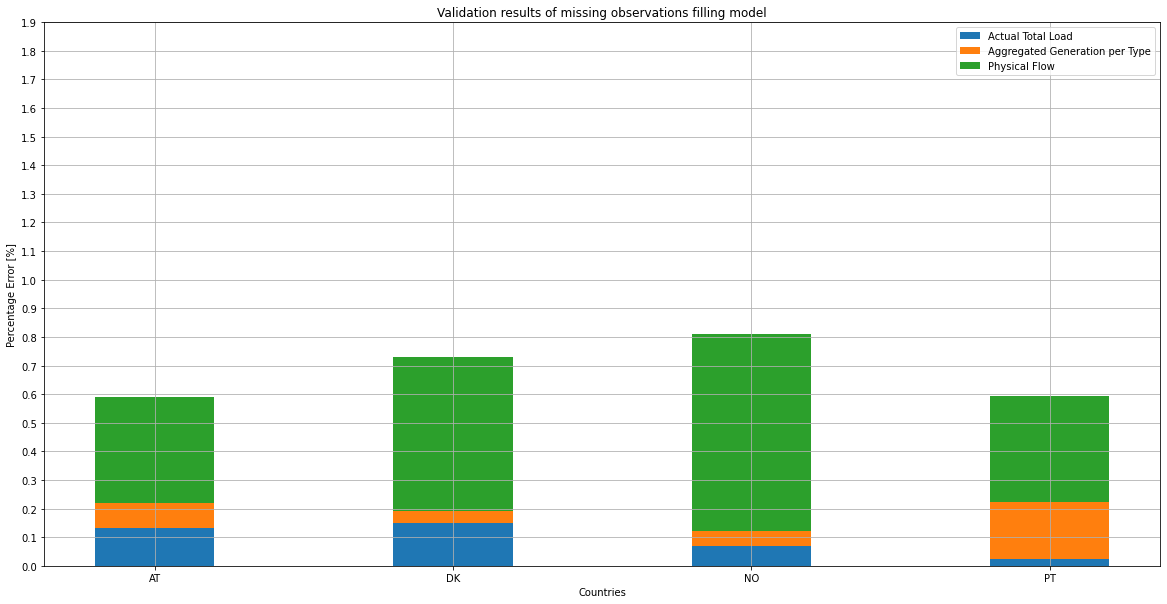

In [ ]:
x = di.keys()
b_tx = list(np.add(generation,load))
plt.figure(figsize=(20, 10))
plt.bar(x, load, 0.4, label='Actual Total Load')
plt.bar(x,generation,0.4,bottom=load,label='Aggregated Generation per Type')
plt.bar(x, tx, 0.4, bottom=b_tx, label='Physical Flow')
plt.xlabel('Countries')
plt.yticks(np.arange(0,2,0.1))
plt.ylabel('Percentage Error [%]')
plt.title('Validation results of missing observations filling model')
plt.grid()
plt.legend()
plt.show()
